# Mental Health Program Discharge Survival Analysis and Modeling
Xiaoyu Yang
<br>
Created on 4/8/24

In [1]:
# data manipulation
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 2000)
pd.options.mode.copy_on_write = True


# survival analysis and modeling
from sksurv.datasets import get_x_y
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.column import standardize
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis, ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    as_cumulative_dynamic_auc_scorer,
)


# sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.inspection import permutation_importance


# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Create feature set and target variable for survival analysis

In [2]:
df = pd.read_csv('./data/mh_discharge_sa.csv').iloc[:, 1:]
target_cols = ['discharge_flag', 'survival_days']
id_cols = ['client_id', 'EOC_KEY_X']
cat_cols = [
    'gender', 'race', 'religion_ind', 'spanish_ind', 
    'opt_interest_ind', 'access_portal_ind', 'referral_source', 'client_ins_type', 
    'pri_prd_gender', 'pri_prd_race', 'pri_prd_emp_type'
]

for col in cat_cols:
    df[col] = df[col].astype('category')

In [3]:
X, y = get_x_y(df.drop(columns = id_cols), attr_labels = target_cols, pos_label = True)

In [4]:
y[:5]

array([( True,  67.), (False,   6.), ( True, 108.), ( True,  57.),
       ( True,  94.)],
      dtype=[('discharge_flag', '?'), ('survival_days', '<f8')])

In [5]:
X.head()

,age,gender,race,religion_ind,spanish_ind,avg_days_between_apps,num_apps,days_from_prev_app,cancelled,no_show,BPS,IOP,OPT,opt_hours_scheduled,opt_interest_ind,access_portal_ind,referral_source,client_ins_type,app_prd_same_gender,app_prd_white,app_prd_black,app_prd_asian,app_prd_hispanic,app_prd_full_time,app_prd_part_time,app_prd_contractor,app_prd_median_tenure,app_prd_median_tenure_ch,pri_prd_gender,pri_prd_race,pri_prd_emp_type,pri_prd_median_tenure,pri_prd_median_tenure_ch
0,14,Nonbinary,White,Y,N,7.444444,10,4.0,0.000000,0.100000,0.100000,0.900000,0.000000,1,Y,N,Other Referral,Other,0.100000,0.700000,0.0,0.100000,0.100000,0.100000,0.000000,0.900000,5.0,0.5,Male,White,employee_full_time,6.0,1.0
1,12,Nonbinary,White,Y,N,6.000000,2,6.0,0.000000,0.000000,0.000000,0.000000,1.000000,1,N,Y,Outpatient Practice,Medicaid,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,3.0,1.0,Male,Asian,contractor,3.0,1.0
2,21,Nonbinary,Other,Y,N,6.000000,19,14.0,0.052632,0.263158,0.052632,0.736842,0.157895,1,Y,Y,Outpatient Practice,Other,0.157895,0.736842,0.0,0.105263,0.000000,0.210526,0.000000,0.736842,5.5,0.5,Female,White,employee_full_time,10.0,2.0
3,18,Female,White,N,N,7.125000,9,6.0,0.000000,0.222222,0.000000,0.888889,0.111111,1,Y,Y,Outpatient Practice,Other,0.666667,0.555556,0.0,0.222222,0.111111,0.000000,0.111111,0.888889,6.0,1.0,Female,Native Hawaiian or Other Pacific Islander,employee_part_time,6.0,0.0
4,19,Female,Other,N,N,23.500000,5,26.0,0.000000,0.400000,0.400000,0.600000,0.000000,1,Y,Y,Other Referral,Medicaid,0.600000,1.000000,0.0,0.000000,0.000000,0.400000,0.000000,0.600000,6.0,1.0,Female,White,employee_part_time,5.0,0.0


In [6]:
# split the data into train and test, and only use the train data set to build and tune the model
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 47, stratify = df.discharge_flag)

In [7]:
print('Shape of training data: ', X_train_val.shape)
print('Shape of testing data:', X_test.shape)

Shape of training data:  (654, 33)
Shape of testing data: (164, 33)


### EDA on survival function
1. From the histogram, most clients were discharged between 60 days to 100 days
2. From the survival function, it is confirmed that most clients got discharged after ~80 days

[Text(0.5, 1.0, 'Distribution of Length of Stay (Days)'),
 Text(0.5, 0, 'Length of Stay (Days)'),
 Text(0, 0.5, 'Number of clients')]

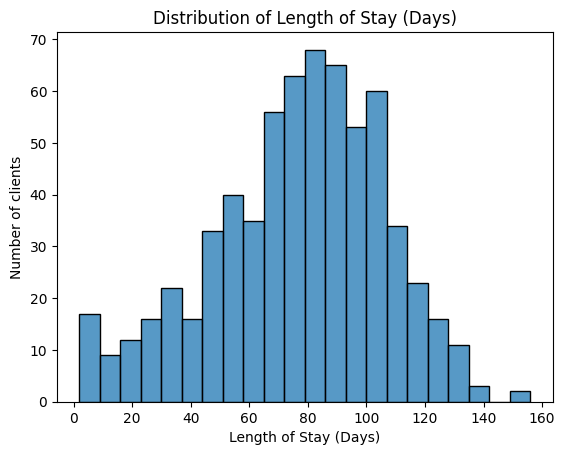

In [8]:
# plot the distribution of survival days
sns.histplot(y_train_val['survival_days'], binwidth = 7).set(
    title = 'Distribution of Length of Stay (Days)',
    xlabel = 'Length of Stay (Days)',
    ylabel = 'Number of clients'
)

Text(0.5, 1.0, 'Survival Function of Successful Discharge')

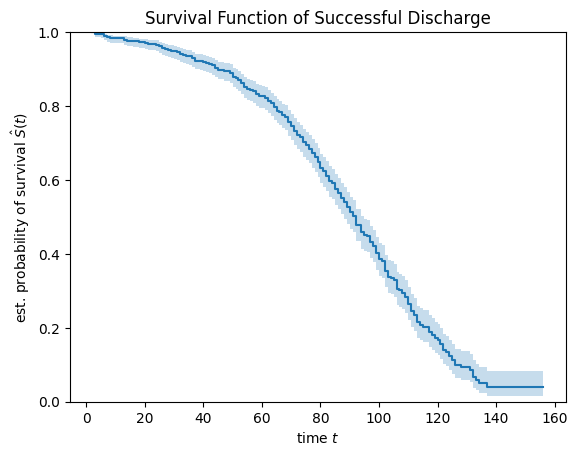

In [9]:
# use Kaplan-Meier estiamtor to plot the survival function
time, survival_prob, conf_int = kaplan_meier_estimator(
    y_train_val['discharge_flag'], 
    y_train_val["survival_days"], 
    conf_type = "log-log"
)

plt.step(time, survival_prob, where = "post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha = 0.25, step = "post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title('Survival Function of Successful Discharge')

In [10]:
# create a function to plot survival functions by different variables
def plot_survival_function(X, y, col_name):

    for col in X[col_name].unique():
        mask = X[col_name] == col
        time, survival_prob, conf_int = kaplan_meier_estimator(
            y['discharge_flag'][mask],
            y["survival_days"][mask],
            conf_type = "log-log",
        )

        plt.step(time, survival_prob, where = "post", label = f"{col_name} = {col}")
        plt.fill_between(time, conf_int[0], conf_int[1], alpha = 0.25, step = "post")

    plt.ylim(0, 1)
    plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc = "best")

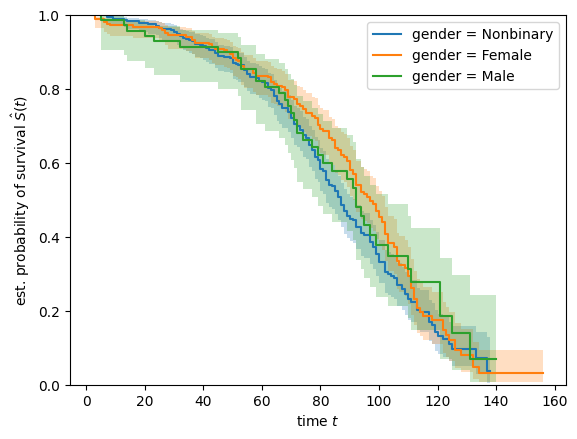

In [11]:
# for example, the survival function doesn't differ much by gender
plot_survival_function(X_train_val, y_train_val, 'gender')

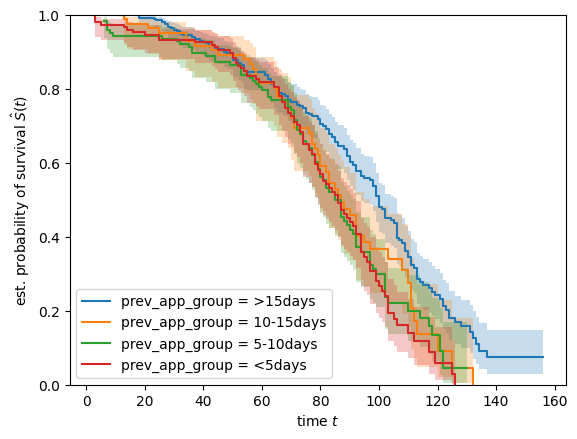

In [12]:
# But there seems to be difference of survival probability by days from previous appointment
X_train_val['prev_app_group'] = pd.cut(
    X_train_val['days_from_prev_app'], 
    bins = [0, 5, 10, 15, X_train_val['days_from_prev_app'].max()], 
    labels = ['<5days', '5-10days', '10-15days', '>15days'], 
    include_lowest = True
)

plot_survival_function(X_train_val, y_train_val, 'prev_app_group')

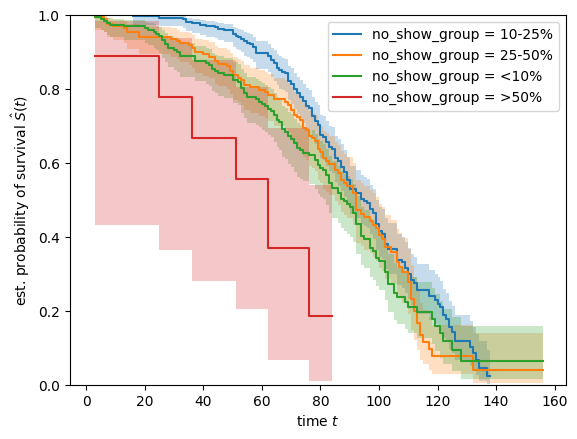

In [13]:
# There are definitely big differences in survival probability between % "No Show" appointments
X_train_val['no_show_group'] = pd.cut(
    X_train_val['no_show'], 
    bins = [0, 0.1, 0.25, 0.5, X_train_val['no_show'].max()], 
    labels = ['<10%', '10-25%', '25-50%', '>50%'], 
    include_lowest = True
)

plot_survival_function(X_train_val, y_train_val, 'no_show_group')

### Select the best model to predict a survival function of CH client for length of stay
There are 34 candidate features that can be leveraged to predict a survival probability for each CH client, and it is more efficient to build a model training pipeline from `sklearn` to streamline data preprocessing, feature selection and model hyperparameter tuning to eventually understand feature importance. The canddiate models are:
1. Cox regression (as a baseline)
2. Cox regression with penalty
3. Random survival forest
4. Gradient boossting machine for survival analysis

<br>
Concordance index with right-censorship is usually the evaluation metric for survival model, but the censorship rate in the data set is ~38% and we care more about the predictability of the model, we need to use metrics that are robust to censorship and can distinguish model performances. We will use concordance index with IPCW and cumulative dynamic AUC score to evaluate the models

In [14]:
X_train_val = X_train_val.drop(columns = ['prev_app_group', 'no_show_group'])
X_train_val.shape, y_train_val.shape

((654, 33), (654,))

In [15]:
# Standardize the numeric variables
X_train_val = standardize(X_train_val)

### Select the model architecture
The function below is to select the model architecture to focus on. Based on time-dependent AUC score, GBM has the best AUC score on validation set

Finished Baseline Cox
Finished Elastic Net Cox
Finished RSF
Finished GBM
Finished Comp. GBM


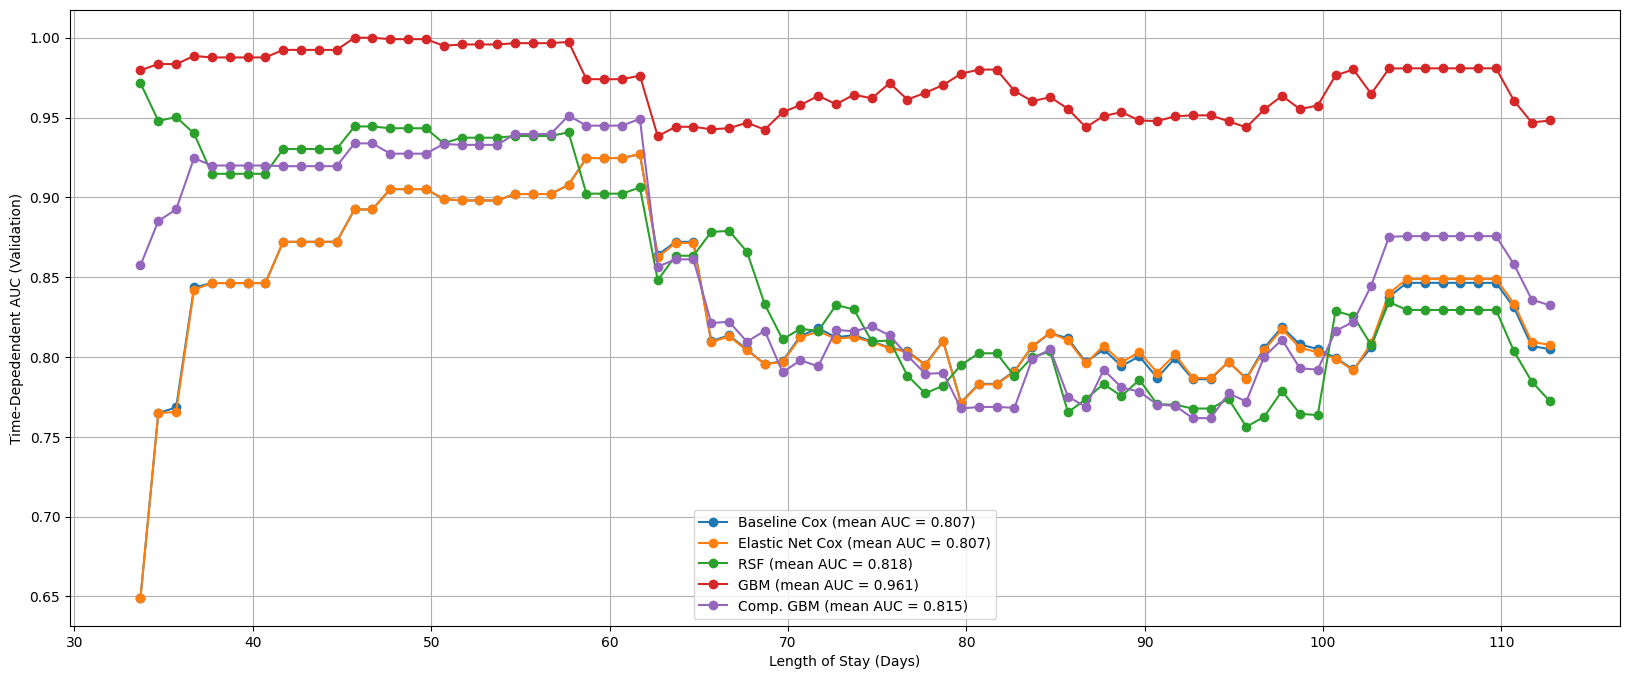

In [16]:
# select the best model architecture
candidate_models = {
    'Baseline Cox': CoxPHSurvivalAnalysis(), # baseline
    'Elastic Net Cox': CoxnetSurvivalAnalysis(), # Elastic Net 
    'RSF': RandomSurvivalForest(n_jobs = -1, random_state = 47),
    'GBM': GradientBoostingSurvivalAnalysis(random_state = 47),
    'Comp. GBM': ComponentwiseGradientBoostingSurvivalAnalysis()
}

# time limits of all data
lower, upper = np.percentile(y['survival_days'], [10, 90])
time_limit = np.arange(lower, upper + 1)

# train/validation split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 47)

# fit each model and report performance metrics
# metrics to consider: concordance index IPCW, cumulative dynamic AUC socre, integrated brier score

model_performance = {
    'model_name': [],
    'c_index_ipcw_train': [],
    'c_index_ipcw_validation': [],
    'mean_auc_train': [],
    'mean_auc_validation': []
}

plt.figure(figsize = (20, 8))

for model_name, model in candidate_models.items():

    # create a pipeline
    pipeline = Pipeline([
        ('encoder', OneHotEncoder()),
        #('feature', SelectKBest(fit_and_score_features)),
        ('estimator', model)
    ])

    # fit the model and make predictions on train and validation sets
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_val_pred = pipeline.predict(X_val)

    # calculate model performance metrics
    c_index_ipcw_train = concordance_index_ipcw(y_train, y_train, y_train_pred)
    c_index_ipcw_val = concordance_index_ipcw(y_train, y_val, y_val_pred)
    auc_train, mean_auc_train = cumulative_dynamic_auc(y_train, y_train, y_train_pred, time_limit)
    auc_val, mean_auc_val = cumulative_dynamic_auc(y_train, y_val, y_val_pred, time_limit)

    # plot AUC over time
    plt.plot(time_limit, auc_val, "o-", label = f"{model_name} (mean AUC = {mean_auc_val:.3f})")
    plt.xlabel("Length of Stay (Days)")
    plt.ylabel("Time-Depedendent AUC (Validation)")
    plt.legend(loc = "lower center")
    plt.grid(True)

    # create output
    model_performance['model_name'].append(model_name)
    model_performance['c_index_ipcw_train'].append(c_index_ipcw_train[0])
    model_performance['c_index_ipcw_validation'].append(c_index_ipcw_val[0])
    model_performance['mean_auc_train'].append(mean_auc_train)
    model_performance['mean_auc_validation'].append(mean_auc_val)

    print(f'Finished {model_name}')

In [17]:
pd.DataFrame(model_performance).sort_values(by = 'mean_auc_validation', ascending = False)

,model_name,c_index_ipcw_train,c_index_ipcw_validation,mean_auc_train,mean_auc_validation
3,GBM,0.926539,0.854764,0.985433,0.961221
2,RSF,0.925372,0.700596,0.982504,0.818159
4,Comp. GBM,0.754602,0.699941,0.874913,0.814902
1,Elastic Net Cox,0.779886,0.705542,0.884914,0.807443
0,Baseline Cox,0.780468,0.705085,0.884433,0.807422


### Hyper-parameter tuning for GBM model
From the previous step, GBM model has the best performance in terms of time-dependent AUC score on validation data set. The following parameters are related to regularization of this model:
1. Loss: if "lpcsls", it is the same as Accelerated Time Failure model
2. learning_rate
3. dropout_rate
4. subsample

In [18]:
# tune the model with fixed number of features
X_train_val = standardize(X_train_val)

# One-hot encoder
one_hot = OneHotEncoder()
one_hot.fit(X_train_val)
X_train_val = one_hot.transform(X_train_val)

In [19]:
model = GradientBoostingSurvivalAnalysis(random_state = 47)

param_set = {
    'estimator__loss': ['coxph', 'ipcwls'],
    'estimator__learning_rate': [0, 0.01, 0.1, 1, 2],
    'estimator__dropout_rate': [0, 0.01, 0.1, 0.5],
    'estimator__subsample': [0.2, 0.5, 1]
}

In [ ]:
grid = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(model, times = time_limit),
    param_grid = param_set,
    cv = KFold(n_splits = 5, shuffle = True, random_state = 47),
    n_jobs = -1
).fit(X_train_val, y_train_val)

### Final model and evaluation on test data


In [21]:
results = pd.DataFrame(grid.cv_results_).sort_values(by = "mean_test_score", ascending = False)
results.loc[:, ~results.columns.str.endswith("_time")].head()

,param_estimator__dropout_rate,param_estimator__learning_rate,param_estimator__loss,param_estimator__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
50,0.01,1,coxph,1,"{'estimator__dropout_rate': 0.01, 'estimator__...",0.978139,0.985005,0.986168,0.984546,0.985748,0.983921,0.002946,1
20,0,1,coxph,1,"{'estimator__dropout_rate': 0, 'estimator__lea...",0.981020,0.982863,0.983318,0.985489,0.985784,0.983695,0.001765,2
56,0.01,2,coxph,1,"{'estimator__dropout_rate': 0.01, 'estimator__...",0.969152,0.974419,0.986170,0.970956,0.980471,0.976234,0.006292,3
49,0.01,1,coxph,0.5,"{'estimator__dropout_rate': 0.01, 'estimator__...",0.974986,0.968006,0.980165,0.978438,0.976424,0.975604,0.004186,4
86,0.1,2,coxph,1,"{'estimator__dropout_rate': 0.1, 'estimator__l...",0.967871,0.973394,0.976578,0.974006,0.974321,0.973234,0.002890,5


In [22]:
# best model from CV
best_model = grid.best_estimator_

# Process the test data 
X_test = standardize(X_test)
X_test = one_hot.transform(X_test)

In [23]:
# make predictions on both train and test data
y_train_val_pred = best_model.predict(X_train_val)
y_train_val_survs = best_model.predict_survival_function(X_train_val)
y_train_val_hazard = best_model.predict_cumulative_hazard_function(X_train_val)

y_test_pred = best_model.predict(X_test)
y_test_survs = best_model.predict_survival_function(X_test)
y_test_hazard = best_model.predict_cumulative_hazard_function(X_test)

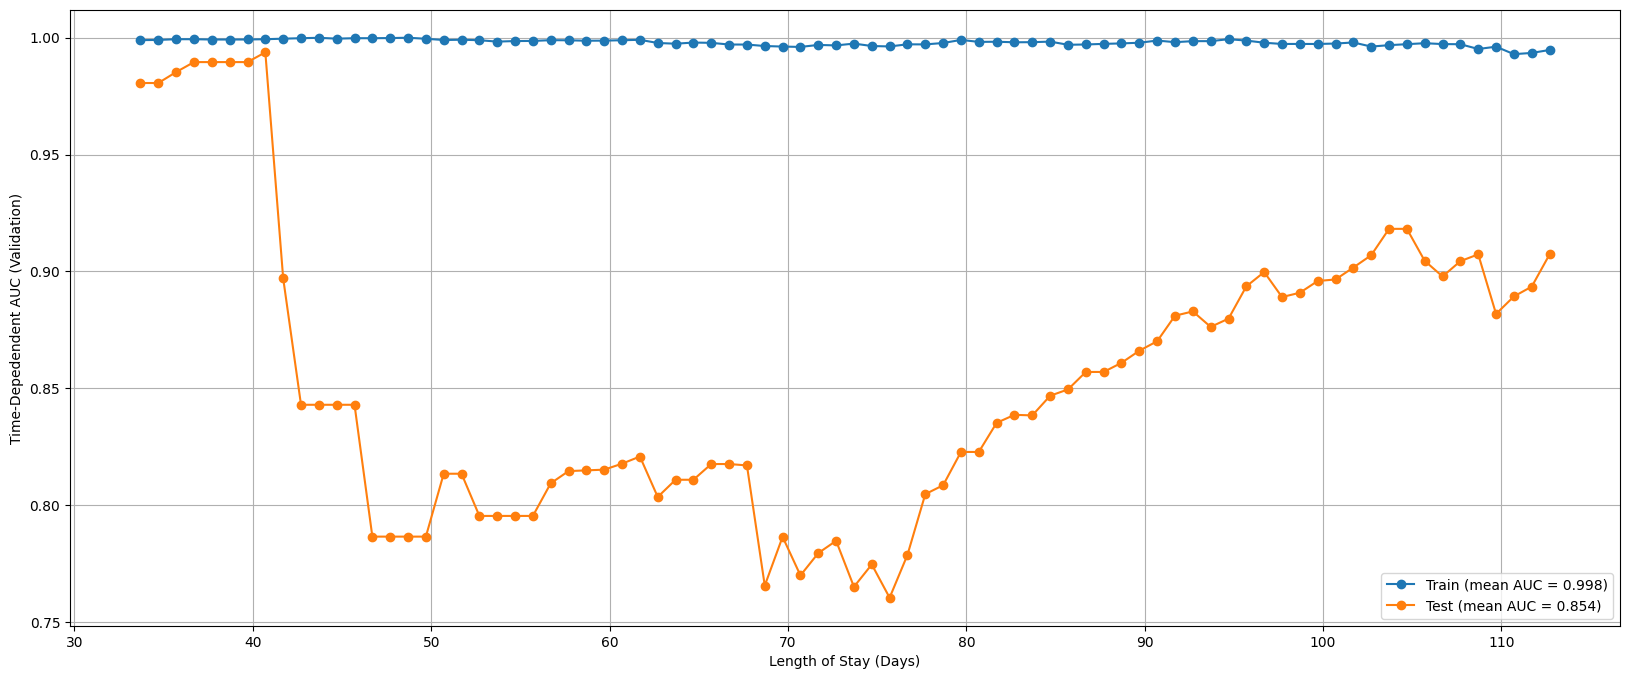

In [24]:
# chart to show time-dependent AUC scores of train and test data
auc_train_val, mean_auc_train_val = cumulative_dynamic_auc(y_train_val, y_train_val, y_train_val_pred, time_limit)
auc_test, mean_auc_test = cumulative_dynamic_auc(y_train_val, y_test, y_test_pred, time_limit)

# plot AUC over time
plt.figure(figsize = (20, 8))
plt.plot(time_limit, auc_train_val, "o-", label = f"Train (mean AUC = {mean_auc_train_val:.3f})")
plt.plot(time_limit, auc_test, "o-", label = f"Test (mean AUC = {mean_auc_test:.3f})")
plt.xlabel("Length of Stay (Days)")
plt.ylabel("Time-Depedendent AUC (Validation)")
plt.legend(loc = "lower right")
plt.grid(True)

### Feature importance

In [25]:
feature_importance = best_model.estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

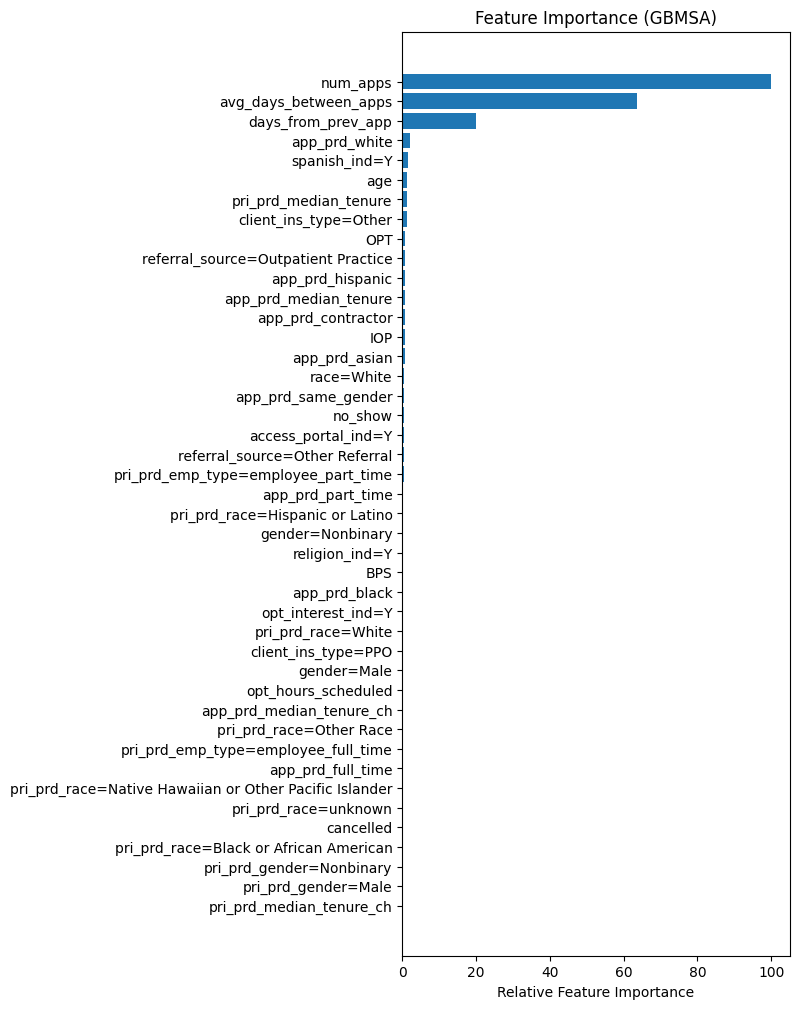

In [26]:
plt.figure(figsize = (5, 12))
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
plt.yticks(pos, X_test.keys()[sorted_idx])
plt.xlabel('Relative Feature Importance')
plt.title('Feature Importance (GBMSA)')
plt.show()

In [27]:
feature_importance_gbsa = permutation_importance(best_model, X_test, y_test, n_repeats = 15, random_state = 47)
permutation_importance_gbsa = pd.DataFrame(
    {
        k: feature_importance_gbsa[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index = X_test.columns,
).sort_values(by = "importances_mean", ascending = False)

permutation_importance_gbsa['relative_importance'] = (permutation_importance_gbsa['importances_mean'] / permutation_importance_gbsa['importances_mean'].max()) * 100

sorted_idx2 = np.argsort(permutation_importance_gbsa['relative_importance'])
pos2 = np.arange(sorted_idx2.shape[0]) + 0.5

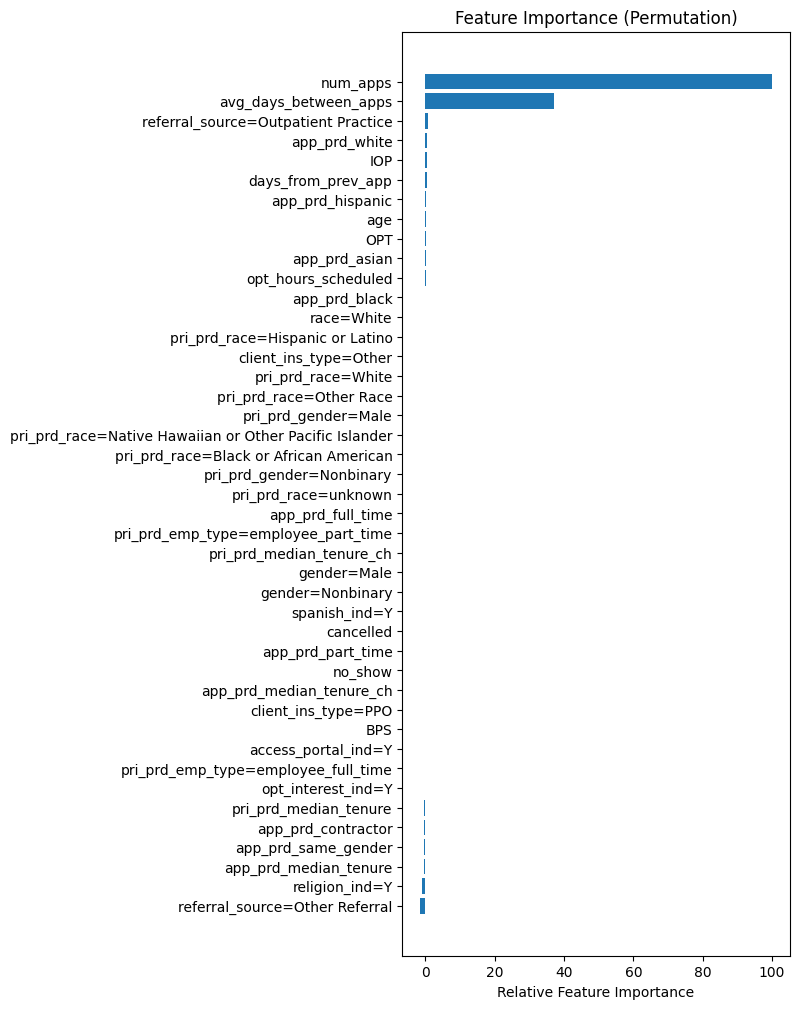

In [28]:
plt.figure(figsize = (5, 12))
plt.barh(pos2, permutation_importance_gbsa['relative_importance'][sorted_idx2], align = 'center')
plt.yticks(pos2, permutation_importance_gbsa.index[sorted_idx2])
plt.xlabel('Relative Feature Importance')
plt.title('Feature Importance (Permutation)')
plt.show()

### How to use the survival model to make business decisions
With survival function, it is possible to calculate the survival probability of any given days in the future. For example, if we want to have a list of clients who might be discharged in the next 30 days, we can create an output using the survival function from the survival model. With that information, the care delivery team can make staffing decisions proactively to ensure better outcomes and experiences for the clients

Text(0.5, 1.0, 'Survival Functions of Discharge within 30 Days')

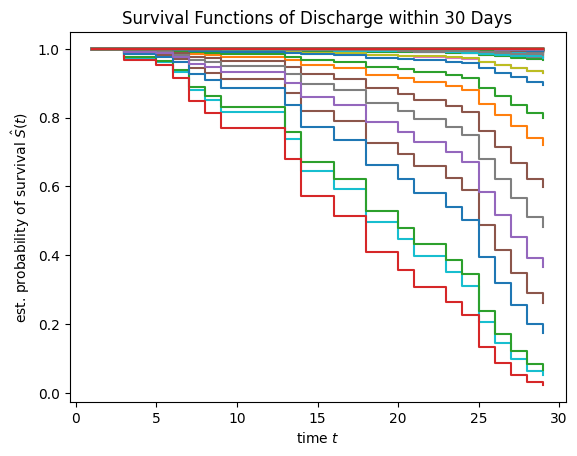

In [29]:
# plot survival functions within 30 days
time_points = np.arange(1, 30)
for i, surv_func in enumerate(y_test_survs):
    plt.step(time_points, surv_func(time_points), where = "post") 
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title('Survival Functions of Discharge within 30 Days')

Text(0.5, 1.0, 'Cumulative Hazard Functions of Discharge within 30 Days')

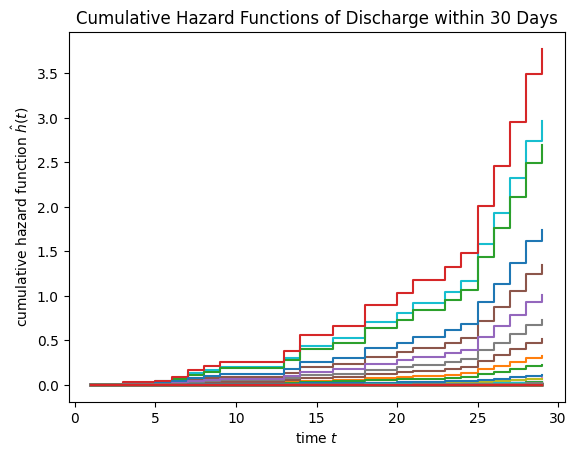

In [34]:
# plot hazard function within 30 days
for i, h_func in enumerate(y_test_hazard):
    plt.step(time_points, h_func(time_points), where = "post") 
plt.ylabel(r"cumulative hazard function $\hat{h}(t)$")
plt.xlabel("time $t$")
plt.title('Cumulative Hazard Functions of Discharge within 30 Days')

In [75]:
# function to create the output with customized days for probability of discharge
def create_discharge_prob_output(test_ids, survival_function, time_interval_days):
    probs = []
    for _, f in enumerate(survival_function):
        prob = f(time_interval_days)
        probs.append(prob)
    
    df_probs = pd.DataFrame(pd.Series(probs, name = f'survival_prob_{time_interval_days}_days'))
    return pd.concat([test_ids, df_probs], axis = 1)

In [76]:
test_ids = df.iloc[X_test.index, 0:2].reset_index(drop = True)
test_output_30_days = create_discharge_prob_output(test_ids, y_test_survs, 30)
test_output_30_days[test_output_30_days.survival_prob_30_days < 0.5].sort_values(by = 'survival_prob_30_days')

,client_id,EOC_KEY_X,survival_prob_30_days
103,brian86@example.com12/4/2006,11134949,0.016952
79,zacharypotter@example.net5/7/1998,11153834,0.040878
102,garciaashley@example.net9/29/2008,9926146,0.054395
120,edward93@example.net6/22/2002,9910619,0.151953
55,mperez@example.com5/24/2010,11898107,0.234465
124,judy57@example.org6/12/2010,10143992,0.336343
87,michaelchen@example.com7/18/2002,12894889,0.456162


In [83]:
pred_survival_days = []
for i in range(len(y_test_survs)):
    f = y_test_survs[i]
    for t in np.arange(1, 157):
        if f(t) == 0:
            pred_survival_days.append(t)
            break

df_pred_surv_days = pd.DataFrame(pd.Series(pred_survival_days, name = 'pred_survival_days'))
pred_survival_days_output = pd.concat([test_ids, df_pred_surv_days], axis = 1)
pred_survival_days_output['pred_survival_weeks'] = pred_survival_days_output.pred_survival_days // 7
pred_survival_days_output.sort_values(by = 'pred_survival_days').head(10)


,client_id,EOC_KEY_X,pred_survival_days,pred_survival_weeks
103,brian86@example.com12/4/2006,11134949,75,10
102,garciaashley@example.net9/29/2008,9926146,78,11
79,zacharypotter@example.net5/7/1998,11153834,78,11
120,edward93@example.net6/22/2002,9910619,82,11
55,mperez@example.com5/24/2010,11898107,83,11
124,judy57@example.org6/12/2010,10143992,86,12
87,michaelchen@example.com7/18/2002,12894889,89,12
5,bryan55@example.org3/7/2003,9692695,92,13
1,lauragilbert@example.com12/27/2009,9409131,97,13
2,potterjoshua@example.net12/3/2008,8226287,99,14


In [84]:
pred_survival_final_output = pd.merge(pred_survival_days_output, test_output_30_days, 'inner', on = ['client_id', 'EOC_KEY_X'])
pred_survival_final_output[pred_survival_final_output.survival_prob_30_days < 0.5].sort_values(by = ['survival_prob_30_days', 'pred_survival_weeks'], ascending = [True, True])

,client_id,EOC_KEY_X,pred_survival_days,pred_survival_weeks,survival_prob_30_days
103,brian86@example.com12/4/2006,11134949,75,10,0.016952
79,zacharypotter@example.net5/7/1998,11153834,78,11,0.040878
102,garciaashley@example.net9/29/2008,9926146,78,11,0.054395
120,edward93@example.net6/22/2002,9910619,82,11,0.151953
55,mperez@example.com5/24/2010,11898107,83,11,0.234465
124,judy57@example.org6/12/2010,10143992,86,12,0.336343
87,michaelchen@example.com7/18/2002,12894889,89,12,0.456162


[Text(0.5, 1.0, 'Distribution of Predicted Length of Stay (Days)'),
 Text(0.5, 0, 'Length of Stay (Days)')]

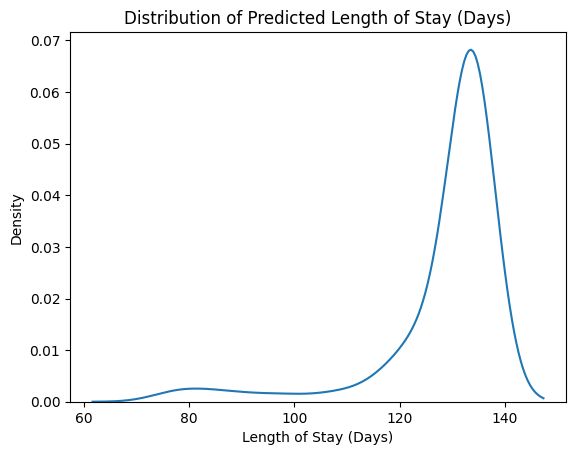

In [93]:
fig, ax = plt.subplots()
sns.kdeplot(pred_survival_final_output['pred_survival_days'], ax = ax).set(
    title = 'Distribution of Predicted Length of Stay (Days)',
    xlabel = 'Length of Stay (Days)'
)

[Text(0.5, 1.0, 'Distribution of Predicted 30-day Survival Probability'),
 Text(0.5, 0, 'Survival Probability of 30 Days')]

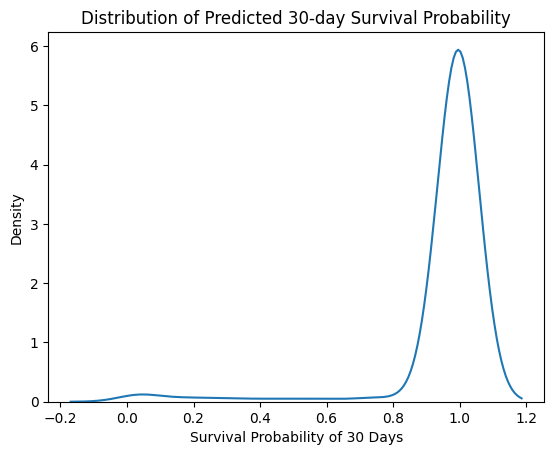

In [94]:
fig, ax = plt.subplots()
sns.kdeplot(pred_survival_final_output['survival_prob_30_days'], ax = ax).set(
    title = 'Distribution of Predicted 30-day Survival Probability',
    xlabel = 'Survival Probability of 30 Days'
)

[Text(0.5, 1.0, 'Distribution of Predicted Length of Stay (Days)'),
 Text(0.5, 0, 'Length of Stay (Days)'),
 Text(0, 0.5, 'Number of clients')]

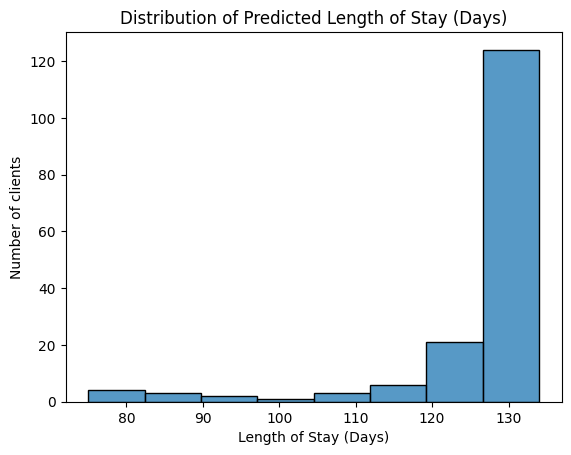

In [85]:
sns.histplot(pred_survival_final_output['pred_survival_days'], binwidth = 7).set(
    title = 'Distribution of Predicted Length of Stay (Days)',
    xlabel = 'Length of Stay (Days)',
    ylabel = 'Number of clients'
)

[Text(0.5, 1.0, 'Distribution of Predicted 30-Day Survival Probability'),
 Text(0.5, 0, 'Survival Probability of 30 Days')]

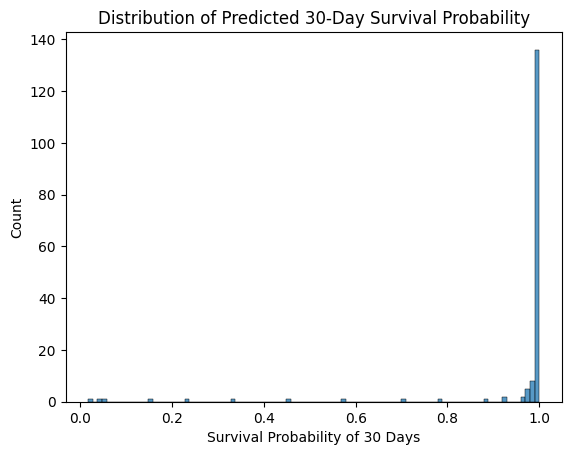

In [102]:
sns.histplot(pred_survival_final_output['survival_prob_30_days'], binwidth = 0.01).set(
    title = 'Distribution of Predicted 30-Day Survival Probability',
    xlabel = 'Survival Probability of 30 Days'
)